<a href="https://colab.research.google.com/github/ZackPashkin/digits-recognition-mm-ocr/blob/main/digits_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Check specs
!nvidia-smi -L
!lscpu 
!echo 'RAM available:' && free -h --si | awk  '/Mem:/{print $2}'
!echo 'Space available: ' && df -h / | awk '{print $4}'
!nvidia-smi

GPU 0: Tesla T4 (UUID: GPU-22541cf3-0058-fae1-9eab-650722a5fb89)
Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               79
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:            0
CPU MHz:             2199.998
BogoMIPS:            4399.99
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            56320K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave

# Training based on the following image:
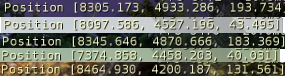




# Results:
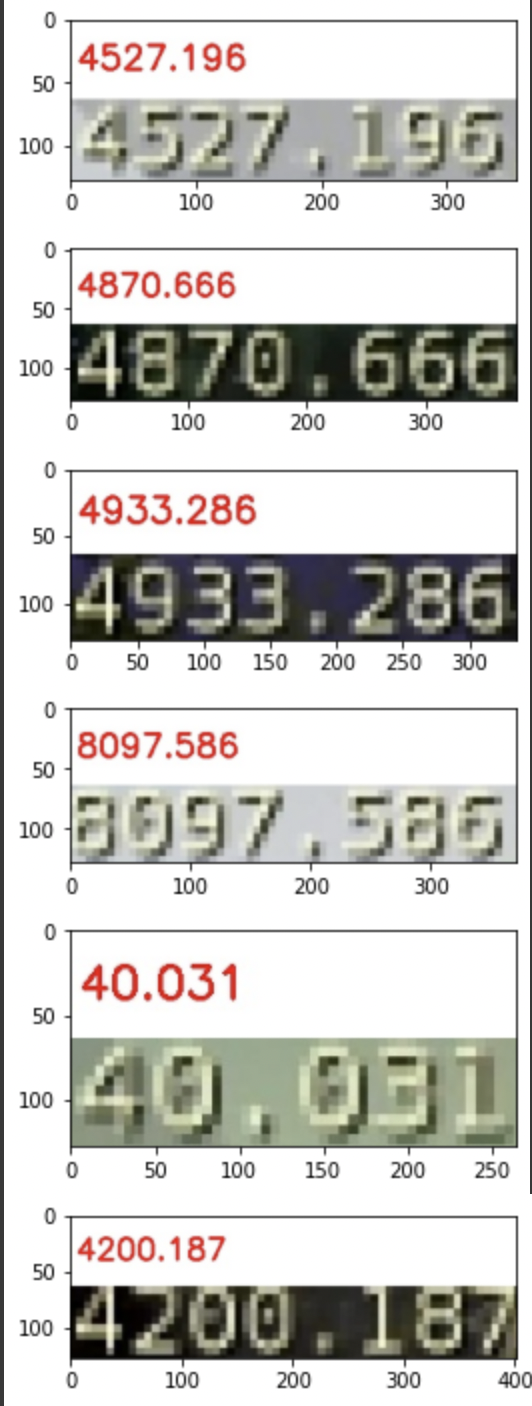

# How to

## Install

In [ ]:
!pip install torch==1.7.1 torchvision==0.8.2 
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu110/torch1.7.1/index.html
!pip install --upgrade mmdet
!git clone https://github.com/open-mmlab/mmocr.git
%cd /content/mmocr
!pip install -r requirements.txt
!pip install -v -e .
# install Pillow 7.0.0 back in order to avoid bug in colab
!pip install Pillow==7.0.0

In [ ]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
import mmcv
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(mmcv.__version__)
print(get_compiling_cuda_version())
print(get_compiler_version())

# Check mmocr installation
import mmocr
print(mmocr.__version__)

1.7.1 True
2.16.0
1.3.13
11.0
GCC 7.5
0.3.0


In [ ]:
%cd /content
!wget https://storage.googleapis.com/tmp_garbage/epoch_5.pth -O /content/mmocr/demo/tutorial_exps/epoch_5.pth
!wget https://storage.googleapis.com/tmp_garbage/dig_ocr.zip -P /content
!unzip -qq /content/dig_ocr.zip 
!mv /content/content/dataset/list_numbers_dataset /content/mmocr
!mv /content/content/dataset/label.txt /content/mmocr
!rm -rf /content/content
!wget https://storage.googleapis.com/tmp_garbage/sar_r31_parallel_decoder_toy_dataset.py -O /content/mmocr/configs/textrecog/sar/sar_r31_parallel_decoder_toy_dataset.py
%cd /content/mmocr

## Visualize

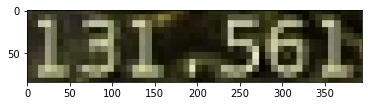

In [ ]:
import mmcv
import matplotlib.pyplot as plt 

img = mmcv.imread('/content/mmocr/list_numbers_dataset/131.561.jpg')
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

## Setup configs

In [ ]:
from mmdet.apis import set_random_seed
from mmcv import Config

cfg = Config.fromfile('./configs/textrecog/sar/sar_r31_parallel_decoder_toy_dataset.py')
# Set up working dir to save files and logs.
cfg.work_dir = './demo/tutorial_exps'
cfg.optimizer.lr = 0.001 / 8
cfg.lr_config.warmup = None
# Choose to log training results every 40 images to reduce the size of log file. 
cfg.log_config.interval = 40

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

## Train model

In [ ]:
from mmocr.datasets import build_dataset
from mmocr.models import build_detector
from mmocr.apis import train_detector
import os.path as osp

# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

/content/mmocr/mmocr/apis/train.py:81: UserWarning: config is now expected to have a `runner` section, please set `runner` in your config.
  'please set `runner` in your config.', UserWarning)
2021-09-13 17:32:23,919 - mmocr - INFO - Start running, host: root@33e48fa6f45c, work_dir: /content/mmocr/demo/tutorial_exps
2021-09-13 17:32:23,921 - mmocr - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(NORMAL      ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) EvalHook                           
(LOW         ) IterTimerHook                      
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_iter:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) EvalHook               

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 150/150, 20.7 task/s, elapsed: 7s, ETA:     0s

2021-09-13 17:33:11,491 - mmocr - INFO - 
Evaluateing label.txt with 150 images now
2021-09-13 17:33:11,501 - mmocr - INFO - Epoch(val) [1][19]	0_word_acc: 0.8667, 0_word_acc_ignore_case: 0.8667, 0_word_acc_ignore_case_symbol: 0.8667, 0_char_recall: 0.9694, 0_char_precision: 0.9794, 0_1-N.E.D: 0.9476
2021-09-13 17:33:21,479 - mmocr - INFO - Epoch [2][40/188]	lr: 1.250e-04, eta: 0:02:12, time: 0.249, data_time: 0.054, memory: 1785, loss_ce: 0.5363, loss: 0.5363
2021-09-13 17:33:29,348 - mmocr - INFO - Epoch [2][80/188]	lr: 1.250e-04, eta: 0:02:06, time: 0.197, data_time: 0.002, memory: 1785, loss_ce: 0.4672, loss: 0.4672
2021-09-13 17:33:37,274 - mmocr - INFO - Epoch [2][120/188]	lr: 1.250e-04, eta: 0:01:59, time: 0.198, data_time: 0.002, memory: 1785, loss_ce: 0.3902, loss: 0.3902
2021-09-13 17:33:45,245 - mmocr - INFO - Epoch [2][160/188]	lr: 1.250e-04, eta: 0:01:52, time: 0.199, data_time: 0.002, memory: 1785, loss_ce: 0.5289, loss: 0.5289
2021-09-13 17:33:50,900 - mmocr - INFO - Sav

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 150/150, 20.0 task/s, elapsed: 7s, ETA:     0s

2021-09-13 17:34:00,682 - mmocr - INFO - 
Evaluateing label.txt with 150 images now
2021-09-13 17:34:00,690 - mmocr - INFO - Epoch(val) [2][19]	0_word_acc: 0.6667, 0_word_acc_ignore_case: 0.6667, 0_word_acc_ignore_case_symbol: 0.6667, 0_char_recall: 0.8061, 0_char_precision: 0.8229, 0_1-N.E.D: 0.7714
2021-09-13 17:34:11,025 - mmocr - INFO - Epoch [3][40/188]	lr: 1.250e-04, eta: 0:01:36, time: 0.258, data_time: 0.054, memory: 1785, loss_ce: 0.3686, loss: 0.3686
2021-09-13 17:34:19,215 - mmocr - INFO - Epoch [3][80/188]	lr: 1.250e-04, eta: 0:01:29, time: 0.205, data_time: 0.002, memory: 1785, loss_ce: 0.3723, loss: 0.3723
2021-09-13 17:34:27,455 - mmocr - INFO - Epoch [3][120/188]	lr: 1.250e-04, eta: 0:01:23, time: 0.206, data_time: 0.002, memory: 1785, loss_ce: 0.3046, loss: 0.3046
2021-09-13 17:34:35,757 - mmocr - INFO - Epoch [3][160/188]	lr: 1.250e-04, eta: 0:01:16, time: 0.208, data_time: 0.002, memory: 1785, loss_ce: 0.2985, loss: 0.2985
2021-09-13 17:34:41,646 - mmocr - INFO - Sav

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 150/150, 19.2 task/s, elapsed: 8s, ETA:     0s

2021-09-13 17:34:51,862 - mmocr - INFO - 
Evaluateing label.txt with 150 images now
2021-09-13 17:34:51,867 - mmocr - INFO - Epoch(val) [3][19]	0_word_acc: 1.0000, 0_word_acc_ignore_case: 1.0000, 0_word_acc_ignore_case_symbol: 1.0000, 0_char_recall: 1.0000, 0_char_precision: 1.0000, 0_1-N.E.D: 1.0000
2021-09-13 17:35:02,460 - mmocr - INFO - Epoch [4][40/188]	lr: 1.250e-05, eta: 0:01:02, time: 0.264, data_time: 0.054, memory: 1785, loss_ce: 0.2826, loss: 0.2826
2021-09-13 17:35:10,895 - mmocr - INFO - Epoch [4][80/188]	lr: 1.250e-05, eta: 0:00:55, time: 0.211, data_time: 0.002, memory: 1785, loss_ce: 0.2602, loss: 0.2602
2021-09-13 17:35:19,305 - mmocr - INFO - Epoch [4][120/188]	lr: 1.250e-05, eta: 0:00:48, time: 0.210, data_time: 0.002, memory: 1785, loss_ce: 0.2665, loss: 0.2665
2021-09-13 17:35:27,685 - mmocr - INFO - Epoch [4][160/188]	lr: 1.250e-05, eta: 0:00:40, time: 0.210, data_time: 0.002, memory: 1785, loss_ce: 0.2444, loss: 0.2444
2021-09-13 17:35:33,574 - mmocr - INFO - Sav

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 150/150, 19.4 task/s, elapsed: 8s, ETA:     0s

2021-09-13 17:35:43,621 - mmocr - INFO - 
Evaluateing label.txt with 150 images now
2021-09-13 17:35:43,628 - mmocr - INFO - Epoch(val) [4][19]	0_word_acc: 1.0000, 0_word_acc_ignore_case: 1.0000, 0_word_acc_ignore_case_symbol: 1.0000, 0_char_recall: 1.0000, 0_char_precision: 1.0000, 0_1-N.E.D: 1.0000
2021-09-13 17:35:54,102 - mmocr - INFO - Epoch [5][40/188]	lr: 1.250e-06, eta: 0:00:27, time: 0.261, data_time: 0.054, memory: 1785, loss_ce: 0.2574, loss: 0.2574
2021-09-13 17:36:02,465 - mmocr - INFO - Epoch [5][80/188]	lr: 1.250e-06, eta: 0:00:20, time: 0.209, data_time: 0.002, memory: 1785, loss_ce: 0.2547, loss: 0.2547
2021-09-13 17:36:10,864 - mmocr - INFO - Epoch [5][120/188]	lr: 1.250e-06, eta: 0:00:12, time: 0.210, data_time: 0.002, memory: 1785, loss_ce: 0.3010, loss: 0.3010
2021-09-13 17:36:19,289 - mmocr - INFO - Epoch [5][160/188]	lr: 1.250e-06, eta: 0:00:05, time: 0.211, data_time: 0.002, memory: 1785, loss_ce: 0.2828, loss: 0.2828
2021-09-13 17:36:25,232 - mmocr - INFO - Sav

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 150/150, 19.2 task/s, elapsed: 8s, ETA:     0s

2021-09-13 17:36:35,424 - mmocr - INFO - 
Evaluateing label.txt with 150 images now
2021-09-13 17:36:35,428 - mmocr - INFO - Epoch(val) [5][19]	0_word_acc: 1.0000, 0_word_acc_ignore_case: 1.0000, 0_word_acc_ignore_case_symbol: 1.0000, 0_char_recall: 1.0000, 0_char_precision: 1.0000, 0_1-N.E.D: 1.0000


## Visualize the results

In [ ]:
from mmocr.apis import init_detector, model_inference
from PIL import Image
import os
from glob import glob

checkpoint = "./demo/tutorial_exps/epoch_5.pth"
model = init_detector(cfg, checkpoint, device="cuda:0")
if model.cfg.data.test['type'] == 'ConcatDataset':
    model.cfg.data.test.pipeline = model.cfg.data.test['datasets'][0].pipeline


for img in glob('/content/mmocr/list_numbers_dataset/*'):
  img_mmcv = mmcv.imread(img)
  result = model_inference(model, img_mmcv)
  print(f'result: {result}')
  img_pred = model.show_result(
          img, result, out_file=out_file, show=False)

  mmcv.imwrite(img_pred, f"outputs/{os.path.basename(img)}")

Use load_from_local loader
result: {'text': '4527.196', 'score': [0.9933629035949707, 0.9726169109344482, 0.9521281719207764, 0.9913153648376465, 0.9994643330574036, 0.9955617189407349, 0.9915063977241516, 0.9981508851051331]}
result: {'text': '4870.666', 'score': [0.9546481370925903, 0.9651076793670654, 0.9798636436462402, 0.9823998212814331, 0.9978777170181274, 0.9969252943992615, 0.9984702467918396, 0.995215892791748]}
result: {'text': '4933.286', 'score': [0.9905960559844971, 0.978559136390686, 0.9956965446472168, 0.9949589967727661, 0.9975540041923523, 0.9866635799407959, 0.9875213503837585, 0.9965028762817383]}
result: {'text': '8097.586', 'score': [0.9941522479057312, 0.9670981168746948, 0.980054497718811, 0.9908592104911804, 0.9993194341659546, 0.9905536770820618, 0.9994625449180603, 0.9952186942100525]}
result: {'text': '40.031', 'score': [0.9824200868606567, 0.9694632887840271, 0.9989516735076904, 0.9918408393859863, 0.9882701635360718, 0.9948374629020691]}
result: {'text': '

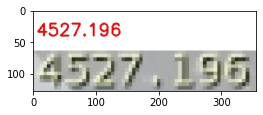

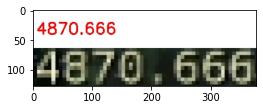

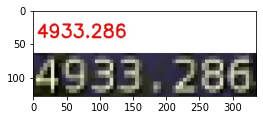

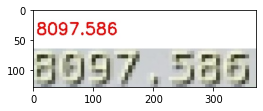

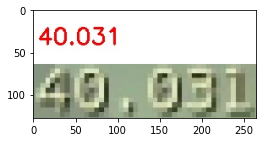

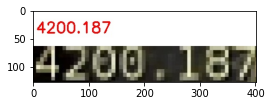

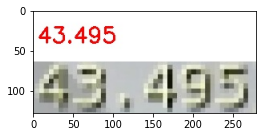

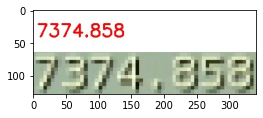

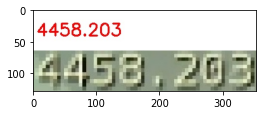

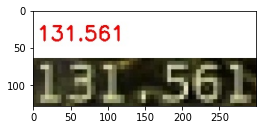

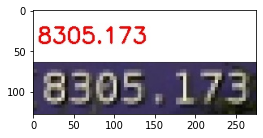

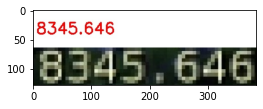

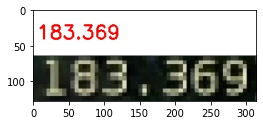

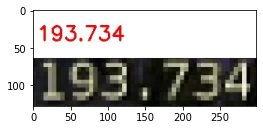

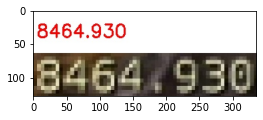

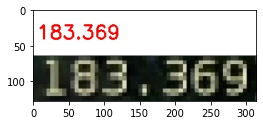

In [ ]:
# Visualize the results
from glob import glob
for img in glob('/content/mmocr/outputs/*'):
  predicted_img = mmcv.imread(img)
  plt.figure(figsize=(4, 4))
  plt.imshow(mmcv.bgr2rgb(predicted_img))
  plt.show()